# Purpose of this notebook

This notebook serves to demonstrate the following workflow to help introduce new users to the UNSAFE framework, and to allow them to test that the code does what it says it does. 

1) Configure the working directory structure and workflow parameters;
2) If you want to make use of the downloading functionality in UNSAFE, download and unzip data;
3) Subset the full structure inventory to single-family structures and convert the data to a GeoDataFrame;
4) Specify a spatial extent of your study area (i.e. county shapefile or a study boundary) and process reference files through clipping (e.g. census tract data);
5) Process expert DDFs for use in ensembles;
6) Process social vulnerability data by linking it with corresponding reference data (e.g. linking Climate and Economic Justice Screening Tool with census tracts);
7) Prepare the National Flood Hazard Layer data for identifying structure location in and outside of the federal floodplain;
8) Link structures to all vector spatial data;
9) Link structures to inundation data, provided as raster(s);
10) Prepare the structure inventory for loss estimation (this base inventory can be used for estimating losses without uncertainty);
11) Generate an ensemble of plausible structure realizations based on several parameters users can specify;
12) Estimate expected annual losses for each ensemble member for a set of design events. Each ensemble member has a unique draw from the DDF distribution. Users can also estimate expected annual losses without uncertainty in exposure and vulnerability. 


We also provide code for producing some visualizations. 

# Configure

In [22]:
# These are options we like setting for working with jupyter notebooks. Totally optional
%load_ext autoreload
%autoreload 2

We load packages (mostly from UNSAFE) to help us get through the workflow.

In [23]:
# Packages
import os
from os.path import join
from pathlib import Path
import yaml
from yaml.loader import SafeLoader
import pandas as pd
import geopandas as gpd

import unsafe.download as undown
import unsafe.files as unfile
import unsafe.unzip as ununzip
import unsafe.exp as unexp
import unsafe.ddfs as unddf
import unsafe.ensemble as unens


Next, we configure spatial units like county fips. Right now, the county is the unit of analysis for UNSAFE. The county fips code is used to download data from the national structure inventory API, and for organzing the directory structure. This facilitates distributed county-level analyses (though we have not tested this yet, and there are likely some things to work out before then). We also keep track of the state fips code (the first two digits of the county code) for downloading data and organizing the file directory. The state abbrevation for a county can be helpful (though it's not currently used). We also have the "Nation" indicator, since damage functions have been produced in other countries. Keeping track of nation is probably not a feature that will remain in UNSAFE in future versions. In future versions, we plan to have state fips and state abbrevation inferred from the user-supplied FIPS code. 

In [24]:
# Name the fips, statefips, stateabbr, and nation that
# we are using for this analysis
# We pass these in as a list even though the framework currently
# processes a single county so that it can facilitate that
# expansion in the future
# TODO - could make sense to define these in the future
# in json or other formats instead of as input in code
fips_args = {
    'FIPS': ['42101'], 
    'STATEFIPS': ['42'],
    'STATEABBR': ['PA'],
    'NATION': ['US']
}
FIPS = fips_args['FIPS'][0]
NATION = fips_args['NATION'][0]


Most of the configuration for UNSAFE is about setting up the file directory structure. Users identify the absolute directory to the root of their project directory and store this in ABS_DIR. This is where we recommend storing a config.yaml file in a `config/` directory. Below, we show all the file directory configurations. 

In [25]:
# We need to pass in a config file that sets up
# constants and the structure for downlading data
# For the directory structure of our case study, 
# we use the following, but you may
# have to specify a different Path
ABS_DIR = Path().absolute().parents[0]


# We are updating the config filename because for this example
# we are using different hazard data. The HAZ_FILEN parameter
# will change values. Everything else is the same. 
CONFIG_FILEP = join(ABS_DIR, 'config', 'config_partial.yaml')
# Open the config file and load
with open(CONFIG_FILEP) as f:
    CONFIG = yaml.load(f, Loader=SafeLoader)

# We can also specify the filepath to the
# raw data directory
FR = join(ABS_DIR, "data", "raw")

# And external - where our hazard data should be
FE = join(FR, "external")

# Set up interim and results directories as well
# We already use "FR" for raw, we use "FO" 
# because you can also think of results
# as output
FI = join(ABS_DIR, "data", "interim")
FO = join(ABS_DIR, "data", "results")

# "Raw" data directories for exposure, vulnerability (vuln) and
# administrative reference files
EXP_DIR_R = join(FR, "exp")
VULN_DIR_R = join(FR, "vuln")
REF_DIR_R = join(FR, "ref")
# Haz is for depth grids
HAZ_DIR_R = join(FE, "haz")
# Pol is for NFHL
POL_DIR_R = join(FR, "pol")

# Unzip directory 
UNZIP_DIR = join(FR, "unzipped")

# We want to process unzipped data and move it
# to the interim directory where we keep
# processed data
# Get the filepaths for unzipped data
# We unzipped the depth grids (haz) and 
# ddfs (vuln) into the "external"/ subdirectory
HAZ_DIR_UZ = join(UNZIP_DIR, "external", "haz")
POL_DIR_UZ = join(UNZIP_DIR, "pol")
REF_DIR_UZ = join(UNZIP_DIR, "ref")
VULN_DIR_UZ = join(UNZIP_DIR, "external", "vuln")

# "Interim" data directories
EXP_DIR_I = join(FI, "exp")
VULN_DIR_I = join(FI, "vuln")
REF_DIR_I = join(FI, "ref")
# Haz is for depth grids
HAZ_DIR_I = join(FI, "haz")
# Pol is for NFHL
POL_DIR_I = join(FI, "pol")

Next, we provide detailed comments on the other things in the config.yaml file.

First we get the files we need downloaded. These are specified in the 'download' key in the config file. We transpose the table because of the way other functions use the DOWNLOAD dictionary.

In [26]:
DOWNLOAD = pd.json_normalize(CONFIG['download'], sep='_').T

Next, we want 'url wildcards' which will help us take the generic urls from the DOWNLOAD dictionary and fill them in with case-study specific deatils. For example, {FIPS} is a wildcard which will be replaced by the FIPS argument you specified in fips_arg for this case study. 

In [27]:
URL_WILDCARDS = CONFIG['url_wildcards']

In [28]:
# Get the file extensions for api endpoints
# In our case study, this is only for downloading from the NSI
API_EXT = CONFIG['api_ext']

# Found the NSI CRS online
NSI_CRS = CONFIG['nsi_crs']

We also have a dictionary of reference names which helps us standardize how we refer to census tract, block group, etc. ids.

In [29]:
REF_NAMES_DICT = CONFIG['ref_names']

We also specify a dictonary of reference id names. This converts things like "GEOID" to "tract_id"

In [30]:
REF_ID_NAMES_DICT = CONFIG['ref_id_names']

In [31]:
# Coefficient of variation
# for structure values
# This is what we scale the structure value by
# to get the standard deviation we draw from
COEF_VARIATION = CONFIG['coef_var']

# First floor elevation dictionary
# This maps foundation types to the triangular distributions
# for first-floor elevation
FFE_DICT = CONFIG['ffe_dict']

# Number of states of the world
# This is the number of ensemble members
N_SOW = CONFIG['sows']

The hazard configuration will vary on a case study by case study basis. In this example, we show you how to define a configuration file that corresponds to a set of design flood event model runs. This type of hazard input allows you to estimate expected annual loss, which we demonstrate later in the tutorial. The below configuration can work on any depth grids from the FEMA Flood Risk Database. We use the riverine flooding products from the database for this case study. We are working on making a larger set of config file examples for different kinds of flood model representations. 

In [32]:
# Get hazard model variables
# Get Return Period list
RET_PERS = CONFIG['RPs']
HAZ_FILEN = CONFIG['haz_filename']
# Get CRS for depth grids
HAZ_CRS = CONFIG['haz_crs']

# Download (and unzip) data

We added download functionality to UNSAFE because it can  help make an analysis more reproducible. Instead of manually downloading hazard, exposure, and vulnerability data from different sources, much of (and sometimes all of) the data needed for a standard risk assessment can be specified using URL or API endpoints. 

We download data with `download_raw(files, wcard_dict, fr, api_ext)` and then unzip data -- both downloaded and user uploaded -- using `unzip_raw(fr, unzip_dir)`. In this partial data example, some of the data is manually uploaded in the `philadelphia_frd/data/raw/external/` directory. When you download UNSAFE, it comes with `external/haz/dg_clip.zip` and `external/vuln/ddfs.zip`. The first directory corresponds to the hazard data we will use for the case study, which originally comes from the Federal Emergency Managemeng Agency (FEMA) Philadelphia Flood Risk Database. You can manually download the data we used by going to [the FEMA Flood Map Service Center: Search All Products](https://msc.fema.gov/portal/advanceSearch#searchresultsanchor) and searching for "FRD_02040202_PA_GeoTIFFs" in the Product ID search box. This data is over 2 GB. You can use this data to follow the `full_data_example.ipynb` notebook. We clipped this raw data to a small spatial extent to allow for the partial example shown here. The second directory, `external/vuln/ddfs.zip`, corresponds to the Depth-Damage Functions, downloaded from [here](https://zenodo.org/records/10027236). This Zenodo repository is well-documented and includes a detailed explanation of where the records are originally from. We manually download these and store them in the data directory for the case study because the URL endpoints for most FEMA Flood Map Service Center products are difficult to identify, and the process for accessing the Zenodo API is somewhat complex. 

The `files` object (specified in CONFIG['DOWNLOAD']) should be structured in a nested dictionary in the following format: SPATIAL_UNIT -> ENDPOINT_TYPE -> COMPONENT -> FILENAME: ENDPOINT. As an example, to download the structures for a county from the NSI, you would specify `FIPS: api: exp: nsi: "https://nsi.sec.usace.army.mil/nsiapi/structures?fips={FIPS}"`. The `wcard_dict` is specified in our configuration step above, and will convert {FIPS} to our county code. "api" tells the function that we are downloading data from an api endpoint (we could also specify url), and exp tells the function that this is an exposure dataset and should be organized in the working directory accordingly. Other "COMPONENT"s include vuln for vulnerability, haz for hazard, pol for policy (e.g. National Flood Hazard Layer), and ref for reference (e.g. censust tract boundaries). We clarify when vulnerability refers to social or physical vulnerability with an additional nested dictionary, like COMPONENT -> SUBCOMPONENT -> FILENAME: ENDPOINT. 

Some endpoints need to be manually specified (e.g. the URL for the National Flood Hazard Layer) because we do not know how to uniquely identify the corresponding data (and the FEMA Help Desk did not respond to our emails asking for guidance). We believe it is a more reproducible practice to specify the download links when possible, as opposed to manually downloading files and uploading them to the working directory. However, users do not have to use the download functionality in UNSAFE. Users could treat all data as external to the UNSAFE workflow, and would configure the working environment accordingly. We recommend putting this data in `ABS_DIR/data/raw/external/` with subdirectories for a specific COMPONENT, but you can modify the filepaths defined above if you'd like to put this data somewhere else. 

`fr` corresponds to the relative filepath to the raw data directory. UNSAFE currently gives users the options to customize the directory structure in the configuration step, but enforces the nested directory structure within that which separates data by SPATIAL_UNIT and COMPONENT. We find that the raw, interim, and results structure provided in this tutorial is helpful for many types of risk assessments. 

The unsafe.download library provides us with convenient functions for quickly dowloading data.

As mentioned before, URL_WILDCARDS has entires like {FIPS} which we are going to replace from the fips_args dictionary we defined. 

In [33]:
wcard_dict = {x: fips_args[x[1:-1]][0] for x in URL_WILDCARDS}
undown.download_raw(DOWNLOAD, wcard_dict,
                    FR, API_EXT)

Downloaded from: https://nsi.sec.usace.army.mil/nsiapi/structures?fips=42101
Downloaded from: https://www.pasda.psu.edu/download/philacity/data/Philadelphia_NFHL_42_2023.zip
Downloaded from: https://web.archive.org/web/20231130105526/https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_42_tract.zip
Downloaded from: https://web.archive.org/web/20240604063409/https://www2.census.gov/geo/tiger/TIGER2022/BG/tl_2022_42_bg.zip
Downloaded from: https://web.archive.org/web/20240608162400/https://www2.census.gov/geo/tiger/TIGER2022/TABBLOCK20/tl_2022_42_tabblock20.zip
Downloaded from: https://dblew8dgr6ajz.cloudfront.net/data-versions/2.0/data/score/downloadable/2.0-communities.csv
Downloaded from: https://web.archive.org/web/20240422040051/https://www2.census.gov/geo/tiger/TIGER2022/COUNTY/tl_2022_us_county.zip
Downloaded from: https://web.archive.org/web/20230627184104/https://www2.census.gov/geo/tiger/TIGER2022/ZCTA520/tl_2022_us_zcta520.zip


We then call the `unzip_raw()` function that unzips any .zip file in raw/ for us. We carefully structured the downloaded data, and the data we uploaded to raw/external/ to make it easier to move files around from raw/ to interim/ to results/ directories and find them later. This is something you can customize.

In [34]:
ununzip.unzip_raw(FR, UNZIP_DIR)

Unzipped: nfhl
Unzipped: zcta
Unzipped: county
Unzipped: bg
Unzipped: tract
Unzipped: block
Unzipped: ddfs
Unzipped: dg_clipped


Both of the functions we just called do a lot of work under the hood for us, calling helper functions in `unsafe.download` and `unsafe.unzip`

# Prepare data for ensemble

This section comprises steps 3 through 9 mentioned at the top of this notebook.

## Exposure

Now that we have downloaded the NSI records for the county, we are going to do some preprocessing for generating our ensemble.

First, we will call `get_nsi_geo()` to use the spatial coordinates from the NSI and prepare a GeoDataFrame. We need the data in this format for linking other attributes needed for loss estimation with the NSI, like flood depths. 

Next, we subset the records from the NSI using SQL-like querying on our pandas DataFrame. 

These steps give us a GeoDataFrame of single family residences for our ensemble. 

For this case study we are focusing on properties with 'RES1' values in the 'occtype' column of the raw NSI data. We willf ocus on properties with at most 2 stories because we have DDFs for 1 and 2 story houses. To clarify, **UNSAFE** is only able to estimate damages for these structures right now, so this subset step is required. We are working to make UNSAFE applicable to a larger set of structure types but are limited by the few DDFs that account for uncertainty in depth-damage relationships. 

In [35]:
nsi_gdf = unexp.get_nsi_geo(FIPS, NSI_CRS, EXP_DIR_R)

# Set the values that we pass into the get_struct_subset
# function. In this case, occtype==RES1 and num_story <= 2
occtype_list=['RES1-1SNB', 'RES1-2SNB', 'RES1-1SWB', 'RES1-2SWB']
sub_string = 'occtype.isin(@occtype_list) and num_story <= 2'

nsi_sub = unexp.get_struct_subset(nsi_gdf,
                                  filter=sub_string,
                                  occtype_list=occtype_list)

# For this case study, let us save some memory and just
# write out the single family houses that we just
# subset. You could write out the nsi_gdf GeoDataFrame
# if you'd like to. 
EXP_OUT_FILEP = join(EXP_DIR_I, FIPS, 'nsi_sf.gpkg')
unfile.prepare_saving(EXP_OUT_FILEP)
nsi_sub.to_file(EXP_OUT_FILEP, driver='GPKG')

Prepared geodataframe


## Reference

We process geospatial reference data (like census tracts and block groups) for three reasons:
1) We will use census tracts to define the unit of aggregation for specifying multinomial distributions for foundation type and number of stories; and
2) Data on social vulnerability, like the Climate and Economic Justice Screening Tool, are available as tabular data so we will link these to the corresponding geospatial reference dataset; and
3) It can be useful to estimate losses at the property-level and then aggregate these estimates to different spatial scales. This is also a common use-case. 

We first define a clip_gdf GeoDataFrame reference to define our study's spatial extent. Here, we use the whole county, but users could upload a specific spatial boundary if they'd like. 

In [36]:
# We are going to clip reference data to a clip file that
# represents our study boundaries. In this case, it's the county
# of Philadelphia, so we will prepare that as our clip file
county_filep = join(REF_DIR_UZ, NATION, 'county', 'tl_2022_us_county.shp')
county_gdf = gpd.read_file(county_filep)
clip_gdf = county_gdf[county_gdf[REF_ID_NAMES_DICT['county']] == FIPS]

# clip_ref_files will go through all unzipped ref files,
# clip them in the clip file geometry, and write them
# We pass in arguments we defined in the configuration step
# to tell the function where the data can be found (REF_DIR_UZ),
# where is is going (REF_DIR_I), and how to update id names
# (REF_NAMES_DICT). 
# Subset of ref downloads
ref_downloads = DOWNLOAD[DOWNLOAD.index.str.contains('_ref_')]
# Clip ref to catchment
# Use FIPS as clip_str since the catchment is in a county
# and this is eaiser for directory management
unexp.clip_ref_files(clip_gdf, FIPS, fips_args, ref_downloads,
                     wcard_dict, REF_DIR_UZ, REF_DIR_I)

Processing reference files...
Found shapefile: tract
Read reference
Reprojected and clipped
Saved Ref: tract
Found shapefile: bg
Read reference
Reprojected and clipped


/Users/f006dwr/miniforge3/envs/unsafe-test/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Saved Ref: bg
Found shapefile: block
Read reference


/Users/f006dwr/miniforge3/envs/unsafe-test/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Reprojected and clipped
Saved Ref: block
Found shapefile: county
Read reference
Reprojected and clipped
Saved Ref: county
Found shapefile: zcta
Read reference
Reprojected and clipped
Saved Ref: zcta


## Physical vulnerability

This is where we call functions to prepare our DDFs for estimating losses under uncertainty. In some analyses, you may only want to use one set of DDFs, so you only have to call one process_DDF() function. In the future, there may be many more functions to draw from, so we decided the workflow would be most transparent if users had to explicitly call a function to process a particular set of DDFs. 

We have separate functions for each DDF because the datasets have slightly different structures and processing requirements. HAZUS DDFs do not have uncertainty 'baked in' so we add noise following [previous research](https://www.nature.com/articles/s41467-020-19188-9) for this case study. You can update the parameter that adds noise and see how it changes the damage estimate distribution. 

In [37]:
unddf.process_naccs(VULN_DIR_UZ, VULN_DIR_I)

UNIF_UNC = .3
unddf.process_hazus(VULN_DIR_UZ, VULN_DIR_I, unif_unc=UNIF_UNC)

Starting NACCS DDF processing...
Loaded 36 NACCS DDF records
Extracting occupancy types and DDF IDs...
Removing unnecessary columns...
Converting to tidy (long) format...
Converting depth-damage functions to tidy (long) format...
Pivoting data to organize damage categories...
Pivot complete with 264 unique depth points
  Interpolating depths for ('1SNB', 'RES1')...
  Interpolating depths for ('1SNB', 'RES3A')...
  Interpolating depths for ('1SWB', 'RES1')...
  Interpolating depths for ('2SNB', 'RES1')...
  Interpolating depths for ('2SWB', 'RES1')...
  Interpolating depths for ('3SNB', 'RES3A')...
  Interpolating depths for ('BCHH', 'RES')...
  Interpolating depths for ('ENC', 'RES')...
  Interpolating depths for ('ENG', 'COM')...
  Interpolating depths for ('OPEN', 'RES')...
  Interpolating depths for ('PRE', 'COM')...
  Interpolating depths for ('URBH', 'RES')...
Parameter lists created for 2292 depth points
Creating maximum depth dictionary for DDFs...
Created dictionary for 12 DDFs

## Social vulnerability

UNSAFE can ingest CDC Socially Vulnerable Index data and Climate and Economic Justice and Screening Tool data. Users do not have to process data about social vulnerability, but it is a common use case. As such, we developed UNSAFE with preliminary functionality for this type of usage. The function we call below calls subroutines that have code to handle the unique features of the different data. 

In [ ]:
# Process national social vulnerability data
# Tell the function which datasets we want processed
# In this case study, we will use cejst
# which is still available nationally and we specified in
# our DOWNLOAD configuration dictionary. 

sovi_list = ['cejst']
unexp.process_national_sovi(sovi_list, FIPS,
                            VULN_DIR_R, REF_DIR_I, VULN_DIR_I)

/Users/f006dwr/proj_tests/unsafe/src/unsafe/exp.py:188: DtypeWarning: Columns (18,29,73,75,88,134) have mixed types. Specify dtype option on import or set low_memory=False.
  cejst = pd.read_csv(ce_filep, dtype={"Census tract 2010 ID": "str"})


Processed cejst


## Policy

The National Flood Hazard Layer is required for using HAZUS DDFs because these apply different DDF relationships based on whether a house is in the V zone. In our case study, all houses are in the A or X zone, but this is a core function that is needed for other case studies. 

In [ ]:
# We need NFHL for the ensemble and visualizations
unexp.process_nfhl(FIPS,
                   POL_DIR_UZ,
                   POL_DIR_I,
                   "Philadelphia_NFHL_42_2023.shp")

Wrote NFHL for county


## Link flood zones and references to structures

We will now link our GeoDataFrame of single family structures to the other spatial data we processed.

In [40]:
# Link flood zones
# We checked for issues like overlapping flood zones
# resulting in NSI structures in multiple polygons
# and did not find any. That's good, but chances
# are there will be counties where this happens
# and we will need code to handle these consistently for other
# case studies
nfhl_filep = join(POL_DIR_I, FIPS, 'fld_zones.gpkg')
nfhl = gpd.read_file(nfhl_filep)
keep_cols = ['fld_zone', 'fld_ar_id', 'static_bfe']

# This function is designed to work in general
# for any spatial-based data you want to link
# to structures. We demonstrate it with the
# nfhl data. 
unexp.get_spatial_var(nsi_sub,
                      nfhl,
                      'fz',
                      FIPS,
                      EXP_DIR_I,
                      keep_cols)

# Link references
# This will do spatial joins for structures within
# all the reference spatial files (besides county)
# and output a file of fd_id (these are unique strucutre ids)
# linked to all of the reference ids
nsi_refs = unexp.get_ref_ids(nsi_sub.set_index('fd_id'), FIPS,
                             REF_ID_NAMES_DICT, REF_DIR_I, EXP_DIR_I)

nsi_ref_filep = join(EXP_DIR_I, FIPS, "nsi_ref.pqt")
unfile.prepare_saving(nsi_ref_filep)
nsi_refs.to_parquet(nsi_ref_filep)

Wrote out: fz
Read ref file: tract
Spatial join with structures
Linked reference to structures: tract_id
Read ref file: block
Spatial join with structures
Linked reference to structures: block_id
Read ref file: bg
Spatial join with structures
Linked reference to structures: bg_id
Read ref file: zcta
Spatial join with structures
Linked reference to structures: zcta_id


## Hazard

This is where we link flood depths to structures. We are using the FEMA Flood Risk Database which consists of the 500, 100, 50, and 10 year return periods. We specified in our configuration file that we are only interested in the depth grids corresponding to inland flooding. The purpose of this function is to do point-in-raster sampling for the depth grids indicated by the RET_PERS and HAZ_FILN arguments. Users can add pre-processing code that is unique to the hazard data they are bringing into the UNSAFE framework to call the `get_inundations()` function. For example, if you want to try experimenting with the `full_data_example.ipynb` you can try adding pre-processing code that selects the max inundation across the inland and coastal depth grids in the Flood Risk Database, and then modify the HAZ_FILEN argument to link these depths to the structures. Or, you can modify the RET_PERS argument to serve more generally as a flood scenario indicator and simultaneously modify the HAZ_FILN argument to accommodate reading in the correct files. 

In [41]:
# Sample the inundation grids and write out the
# fd_id/depths dataframe

# This code looks different than the full data example
# because we created the zip directory in a different way
# than the zip directory you download from the fema
# risk database
haz_dir_uz_clip = join(HAZ_DIR_UZ, 'dg_clipped')
depth_df = unexp.get_inundations(nsi_sub,
                                 HAZ_CRS, RET_PERS,
                                 haz_dir_uz_clip, HAZ_FILEN)

# Because we are processing design-event based flood scenarios,
# we can provide more helpful column names to prepare our loss
# and expected annual loss calculations. We will also
# write out our dataframe. 
ncol = [str(round(100/float(x.replace('_', '.')))) for x in depth_df.columns]
depth_df.columns = ncol

# Write out dataframe that links fd_id to depths
# with columns corresponding to ret_per (i.e. 500, 100, 50, 10)
# in our case study
nsi_depths_out = join(EXP_DIR_I, FIPS, 'nsi_depths.pqt')
unfile.prepare_saving(nsi_depths_out)
depth_df.reset_index().to_parquet(nsi_depths_out)

Store NSI coordinates in list
Read in 0_2 depth grid
Sampled depths from grid
Added depths to list

Read in 01 depth grid
Sampled depths from grid
Added depths to list

Read in 02 depth grid
Sampled depths from grid
Added depths to list

Read in 10 depth grid
Sampled depths from grid
Added depths to list



# Generate ensemble

This corresponds to steps 10-12 in the workflow. We include example code for estimating losses without uncertainty on the base dataframe that is used for generating the ensemble. 

This is the core of what **UNSAFE** does. We generate ensemble members (sometimes called states of the world, or SOWs) based on user defined inputs. Users pass nsi_sub, the full dataframe of single family structures, to help the function learn the proportions of structure types at census tract scale across a case study. They also pass base_df that stores valuable information about the houses at risk of flooding in the case study. Then, users pass a list of DDFs and structure types. In this case study, we estimate damages for NACCS and HAZUS DDFs with uncertainty in first-floor elevation, structure value, number of stories, and basement type. The other arguments are defined by their default values in the `get_loss_ensemble` method.  VULN_DIR_I is a directory path for where we put our DDFs that are ready to estimate losses under uncertainty.

In [ ]:
run_config = {
    'ddfs': ['hazus', 'naccs'],
    'struct_list': ['ffe', 'val_struct', 'num_story', 'found_type'],
    'base_adj': False
}

base_df = nsi_sub.set_index('fd_id')
# We only want the RES1 classification from the NSI
# for damage function assignments
# (not their 1SWB, etc., type classifications)
base_df['occtype'] = base_df['occtype'].str[:4].copy()
# We can easily read in our census tract links from above,
# but we use this shortcut in the interest
# of keeping the tutorial more readable and 
# focused on functionality
base_df['tract_id'] = base_df['cbfips'].str[:11]
# For HAZUS DDFs, we need to link a property to its
# flood zone. Since Philadelphia is not subject to 
# wave action, we automatically use the A zone
# curves (as opposed to Z). For other
# case studies, if V zones are appropriate,
# you need to merge in the flood zone data
# we linked to parcels above
base_df['fz_ddf'] = 'A'

ens_df_f = unens.get_loss_ensemble(base_df,
                                   depth_df,
                                   run_config,
                                   VULN_DIR_I)

Generating ensemble with 1000 states of the world...
Uncertain characteristics: ['ffe', 'val_struct', 'stories', 'basement']
Draw values
Draw stories
Draw foundation types
Generated structure characteristics
DDF: hazus
Losses estimated: 500
Losses estimated: 100
Losses estimated: 50
Losses estimated: 10
DDF: naccs
Losses estimated: 500
Losses estimated: 100
Losses estimated: 50
Losses estimated: 10
Estimated losses
Prepared final ensemble


Because the flood events we used are defined as return periods, we can estimate expected annual loss. We do subsetting the loss columns and calling the `get_eal()` function on an ordered list from most to least frequent return period (e.g., 10 year event is ordered before the 500 year event). It is easiest to do this by looping through the damage functions. 

In [43]:
eals = {}
for ddf in ['hazus', 'naccs']:
    col_sub = [x for x in ens_df_f if ddf + '_loss' in x]
    loss_sub = ens_df_f[col_sub]
    # Update column name to remove reference to ddf
    loss_sub.columns = ['_'.join(x.split('_')[1:]) for x in col_sub]
    ret_per_ints = [int(x.split('_')[-1]) for x in col_sub]
    rp_list = sorted(ret_per_ints)
    eals[ddf] = unddf.get_eal(loss_sub, rp_list)
eals = pd.DataFrame.from_dict(eals)
eals.columns = [x + '_eal' for x in eals.columns]
ens_df_out = pd.concat([ens_df_f, eals], axis=1)

Calculated EAL
Calculated EAL


In [44]:
# Save dataframes
base_out_filep = join(FO, 'base_df.pqt')
unfile.prepare_saving(base_out_filep)
base_df.to_parquet(base_out_filep)

ens_out_filep = join(FO, 'ensemble.pqt')
ens_df_out.to_parquet(ens_out_filep)

## Estimate benchmark losses

In [45]:
# We also want benchmark estimates without uncertainty 
# which we can do with the full_df specified above
nounc_df = unens.benchmark_loss(base_df, depth_df, VULN_DIR_I, base_adj=False)
rp_list = sorted([int(x.split("_")[-1]) for x in nounc_df.columns])
eals = unddf.get_eal(nounc_df, rp_list)

nounc_df = pd.concat([nounc_df, pd.Series(eals, name='eal')], axis=1)

hazus_def_out_filep = join(FO, 'benchmark_loss.pqt')
unfile.prepare_saving(hazus_def_out_filep)
nounc_df.to_parquet(hazus_def_out_filep)

Estimate Losses for Hazus Default, RP: 500
Estimate Losses for Hazus Default, RP: 100
Estimate Losses for Hazus Default, RP: 50
Estimate Losses for Hazus Default, RP: 10
Estimate losses
Calculated EAL


# Checking aggregate results

You can run the code below to compare the histograms of the expected annual loss estimates for both damage functions. You will not get the exact same result each time you run this notebook, but you should get something very similar! You can compare your output to the picture in `examples/phil_frd_partial/fig/example_output.png` 

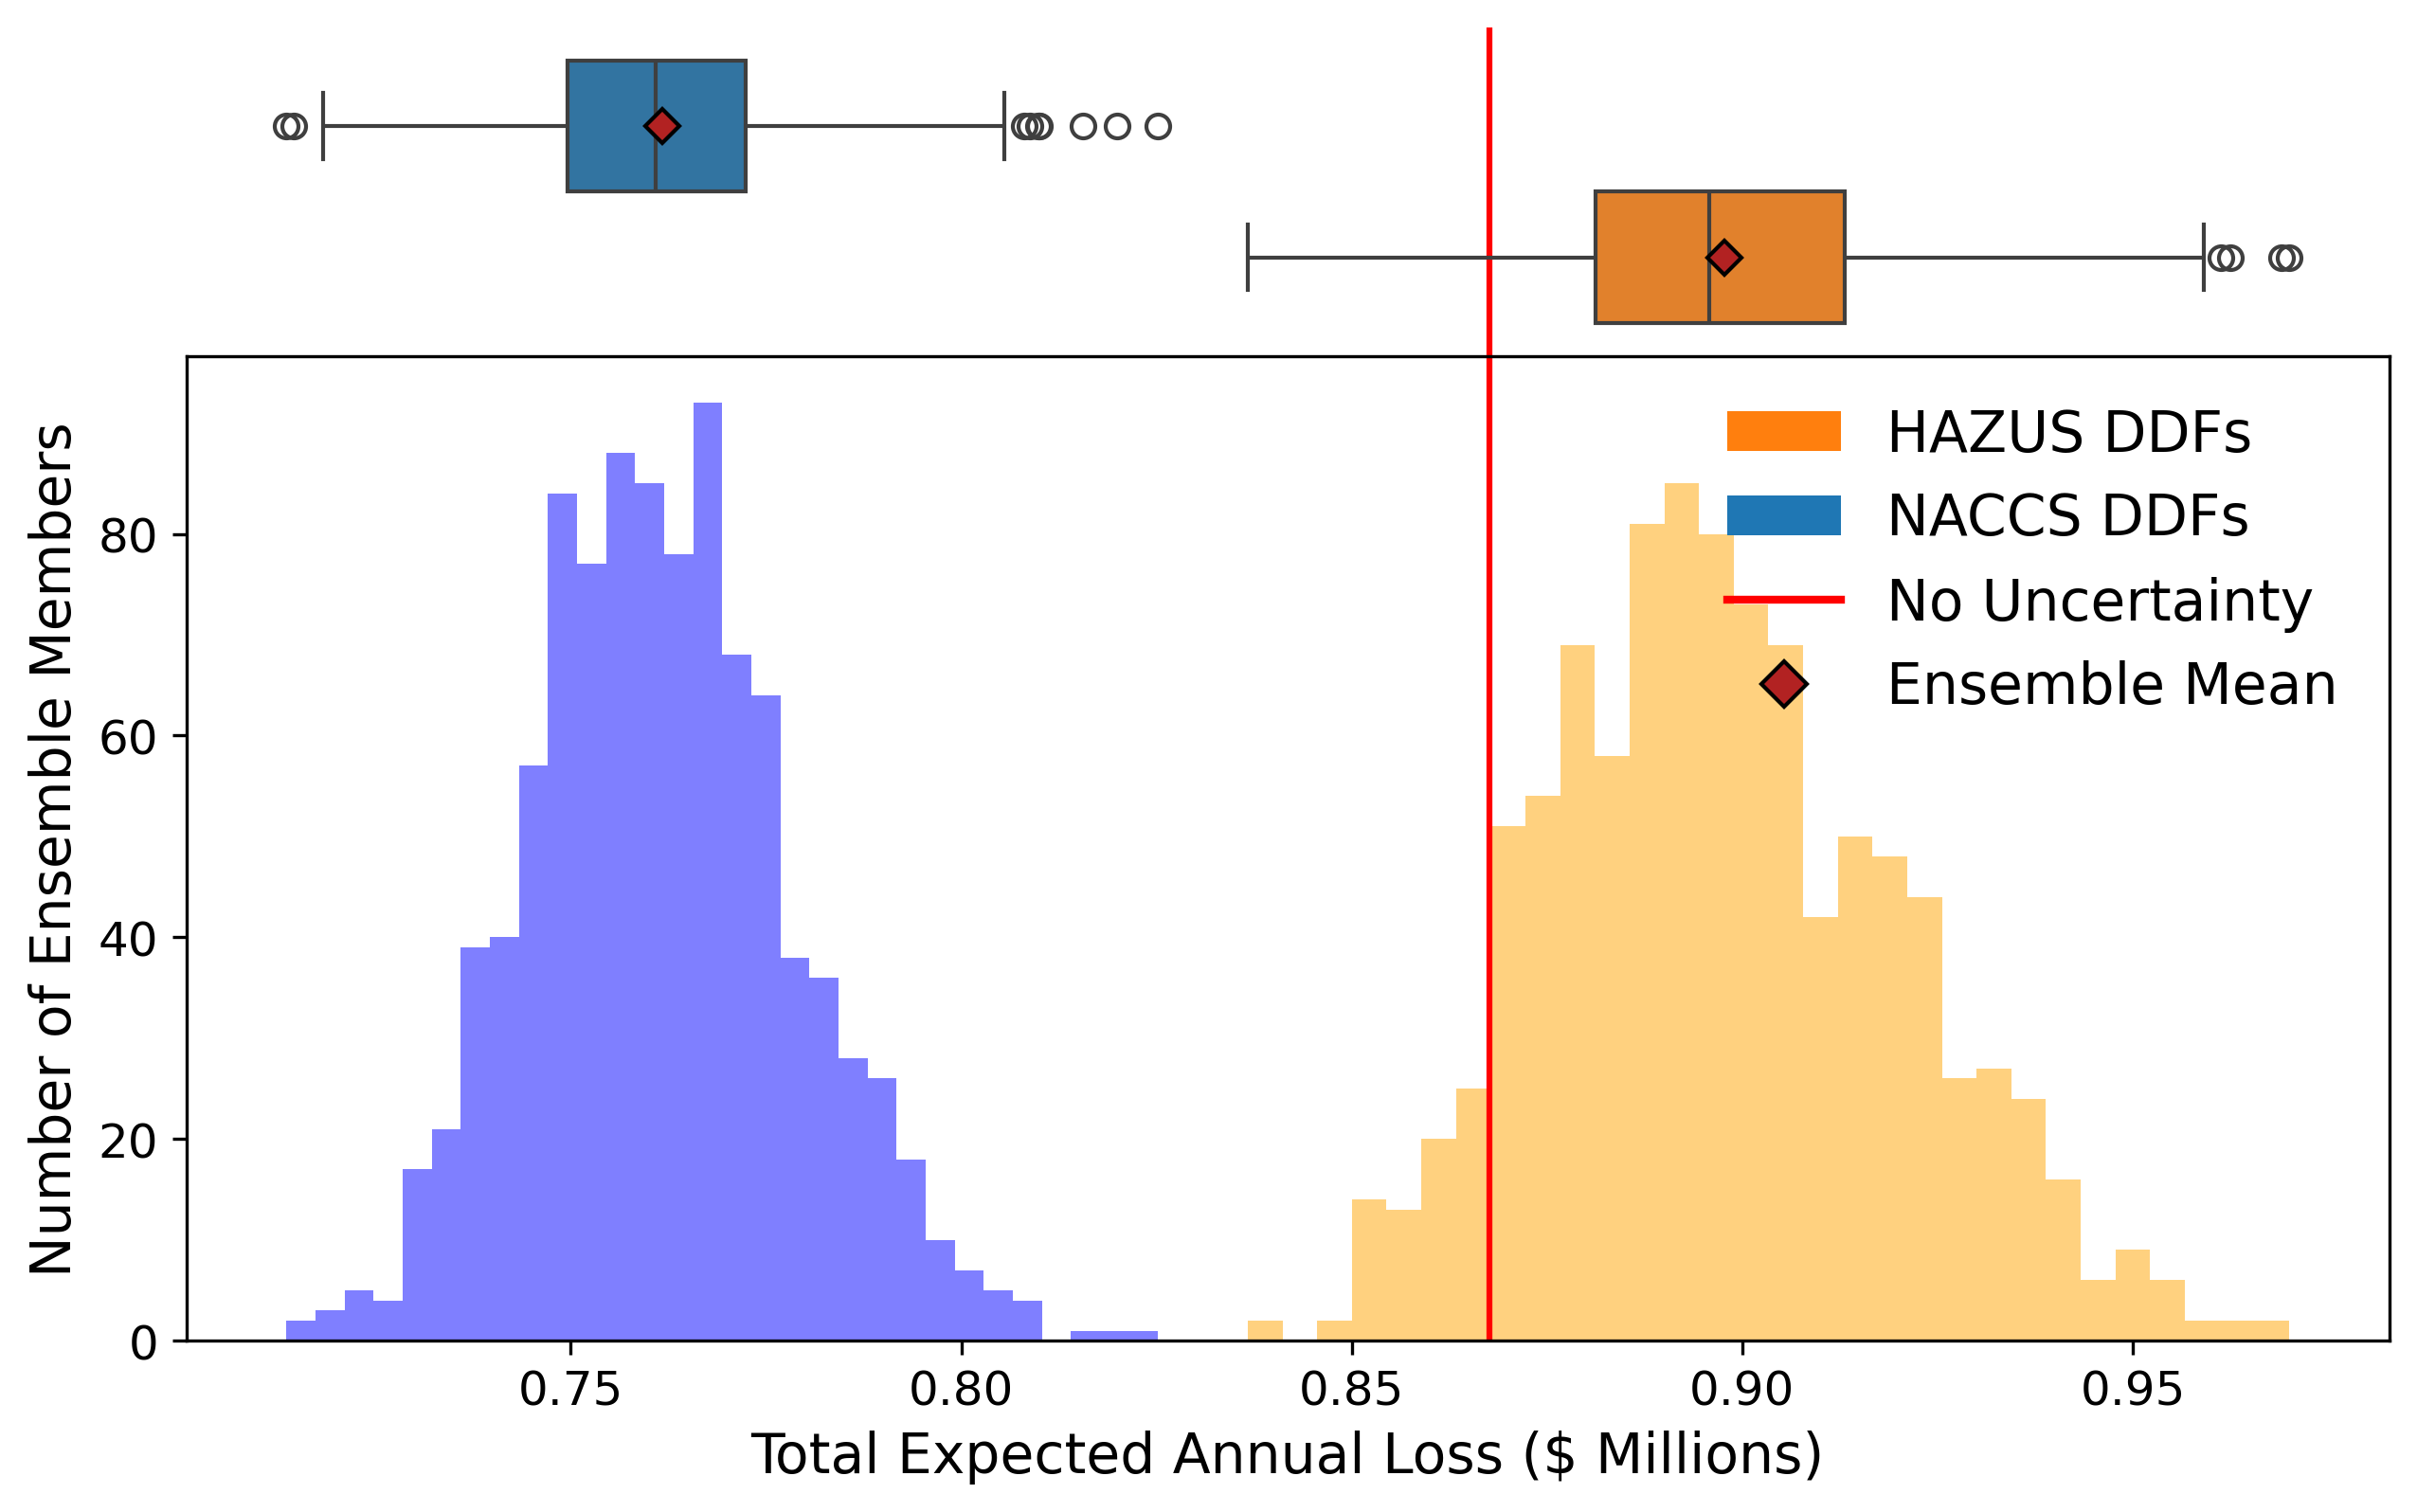

In [46]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6), dpi=300,
                       nrows=2,
                       sharex=True,
                       gridspec_kw={'hspace': 0},
                       height_ratios=[1,3])
# When we groupby 'sow_ind' we are looking across ensemble members
temp = ens_df_out.groupby(['sow_ind'])[['naccs_eal', 'hazus_eal']].sum()/1e6
temp['naccs_eal'].hist(bins=30, color='blue', alpha=.5, label='NACCS DDFs')
temp['hazus_eal'].hist(bins=30, color='orange', alpha=.5, label='HAZUS DDFs')
ax[1].axvline(nounc_df['eal'].sum()/1e6, color='red', label='No Uncertainty')
ax[0].axvline(nounc_df['eal'].sum()/1e6, color='red', label='No Uncertainty')
ax[1].grid(False)
ax[1].set_xlabel('Total Expected Annual Loss ($ Millions)', size=14)
ax[1].set_ylabel('Number of Ensemble Members', size=14)
ax[1].tick_params(labelsize=12)

temp.columns = ['NACCS', 'HAZUS']
temp_box = temp.melt(value_name='eal',
                     var_name='DDF Type')
sns.boxplot(ax=ax[0],
            data=temp_box,
            x='eal',
            hue='DDF Type',
            legend=False,
            showmeans=True,
            meanprops={'markerfacecolor': 'firebrick',
                        'markeredgecolor': 'black',
                        'marker': 'D'})
ax[0].axis('off')


# Easier to do a custom legend
legend_elements = [Patch(facecolor=sns.color_palette("tab10")[1],
                         label='HAZUS DDFs'),
                    Patch(facecolor=sns.color_palette("tab10")[0],
                         label='NACCS DDFs'),
                   Line2D([0], [0], color='r', lw=2, label='No Uncertainty'),
                   Line2D([0], [0], marker='D', markerfacecolor='firebrick',
                          label='Ensemble Mean',
                          ls='',
                          markeredgecolor='black', markersize=8),]


ax[1].legend(handles=legend_elements,
             loc='upper right',
             fontsize='x-large',
             frameon=False)